In [16]:
import tensorflow as tf

In [17]:
# Creating synthetic sequential data
import numpy as np

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

series = baseline + trend(time, slope)
series += seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [18]:
# Convolutions can also be used to detect patterns in sequencs
# but we would have to convert our sequence data into a tensor
# then we would used 1D convolutions to detect patterns in the sequences

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(
    lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [19]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)   

# Build the model using Conv1D layers
model = tf.keras.models.Sequential([
    # 1D convolutional layer
    # padding="causal" ensures the output at time t only depends on inputs at or before time t
    # only take data from the current and previous time steps, never future ones
    # this is important for time series forecasting to prevent data leakage
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.Dense(16, activation="relu"), # we use relu to reject negative values
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=30, verbose=1)


Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1493.6072
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 138.4446
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 74.0738
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 71.1649
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 68.2940
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 68.1689
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 68.2837
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 64.4979
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 65.7166
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 67.8453
Epoch 11/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 70.3942
Epoch 12/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 67.7270
Epoch 13/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 65.5111
Epoch 14/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 66.3882
Epoch 15/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 62.8558
E

In [20]:
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

In [21]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

forecast = model_forecast(model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


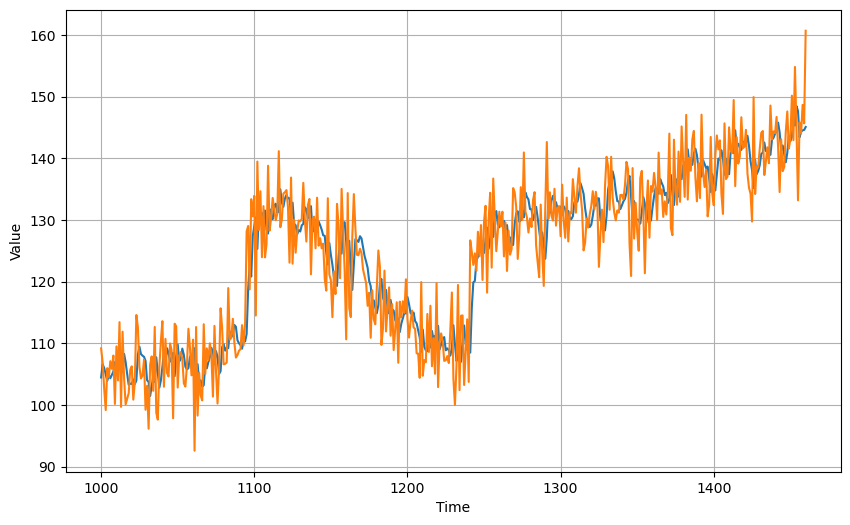

In [22]:
plt.figure(figsize=(10, 6))
plot_series(time[split_time:], results)
plot_series(time[split_time:], series[split_time:])

In [23]:
mae = tf.keras.metrics.MeanAbsoluteError()
mae(series[split_time:], results).numpy()

4.6093388

In [64]:
# It did quite well, nice
# Experiment with different architectures and hyperparameters to improve performance


def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(
    filters=hp.Int('units',min_value=16, max_value=20, step=2), 
    kernel_size=hp.Int('kernels', min_value=3, max_value=6, step=3),
    strides=hp.Int('strides', min_value=1, max_value=2, step=1),
    padding='causal', activation='relu', input_shape=[None, 1]
    ))
    
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss = 'mse', optimizer=tf.keras.optimizers.SGD(
    learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-5]), momentum=0.9))
    
    return model

import keras_tuner as kt

tuner = kt.RandomSearch(
    build_model,
    objective='loss',
    max_trials=7,
    executions_per_trial=3,
    directory='ch11_cnn_rnn_time_series',
    project_name='cnn_rnn_time_series'
)

tuner.search(dataset, epochs=50, verbose=1)

Trial 7 Complete [00h 00m 58s]
loss: 727.9328206380209

Best loss So Far: 60.34797032674154
Total elapsed time: 00h 06m 12s


In [65]:
## Summary of the results from the tuner
tuner.results_summary()

Results summary
Results in ch11_cnn_rnn_time_series\cnn_rnn_time_series
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 5 summary
Hyperparameters:
units: 20
kernels: 6
strides: 1
learning_rate: 1e-05
Score: 60.34797032674154

Trial 0 summary
Hyperparameters:
units: 20
kernels: 3
strides: 2
learning_rate: 0.0001
Score: 722.765380859375

Trial 3 summary
Hyperparameters:
units: 20
kernels: 3
strides: 1
learning_rate: 0.0001
Score: 725.5520629882812

Trial 1 summary
Hyperparameters:
units: 16
kernels: 6
strides: 2
learning_rate: 0.0001
Score: 727.2977091471354

Trial 6 summary
Hyperparameters:
units: 20
kernels: 6
strides: 2
learning_rate: 0.0001
Score: 727.9328206380209

Trial 2 summary
Hyperparameters:
units: 16
kernels: 3
strides: 2
learning_rate: 0.0001
Score: 727.9617919921875

Trial 4 summary
Hyperparameters:
units: 18
kernels: 6
strides: 1
learning_rate: 0.0001
Score: nan


In [ ]:
# Using RNNs

# Generating synthetic sequential data#
mean = np.mean(series)
std = np.std(series)
series = (series - mean) / std # Normalize the data
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()   # <-- IMPORTANT
    dataset = dataset.prefetch(1)
    return dataset

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)   



model = tf.keras.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.SimpleRNN(100, return_sequences=True),
    tf.keras.layers.SimpleRNN(100),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1.5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), 
    optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100,  verbose=1, steps_per_epoch=split_time // batch_size)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1495 - mae: 0.4351
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1427 - mae: 0.4264
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1370 - mae: 0.4189
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1325 - mae: 0.4127
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1288 - mae: 0.4078
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1258 - mae: 0.4037
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1232 - mae: 0.4002
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1210 - mae: 0.3968
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1190 - mae: 0.3938
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1172 - mae: 0.3911
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1154 - mae: 0.3883
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1139 - mae: 0.3857
Epoch 13/100
31/31 ━━━━━━

In [78]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]
results

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


C:\Users\Yusuf Solomon\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

9.439198


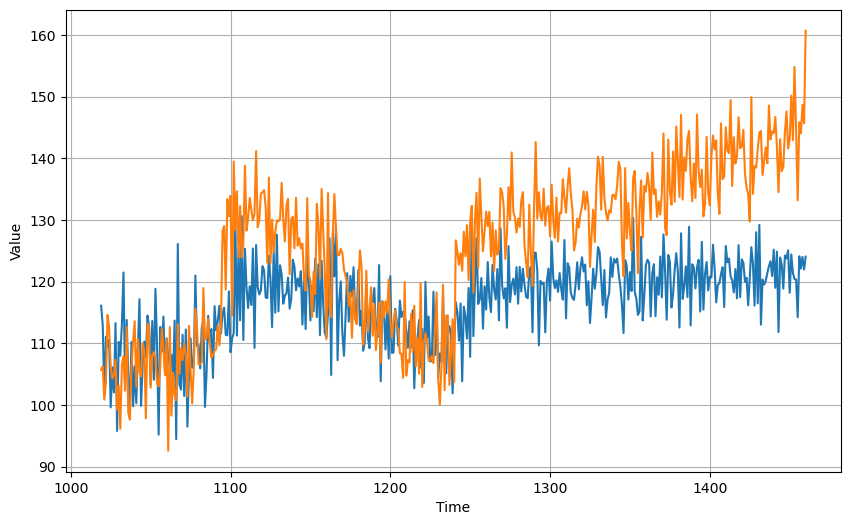

In [ ]:
results = forecast * std + mean
mae = tf.keras.metrics.MeanAbsoluteError()
MAE = mae(series[window_size -1:], results).numpy()
print(MAE)

plt.figure(figsize=(10, 6))
plot_series(time[split_time+ window_size -1:], results[split_time:])
plot_series(time[split_time+ window_size -1::], series[split_time+ window_size -1::])

In [ ]:
# Using LSTM (Long Short Term Memory) RNN

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=[None, 1], return_sequences=True, dropout = 0.1, recurrent_dropout = 0.1),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(1)
    ]) # Dropout randomly drops input values 
# While recurrent dropout randomly drops the recurrent values

optimizer = tf.keras.optimizers.SGD(learning_rate=1.5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), 
    optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100,  verbose=1, steps_per_epoch=split_time // batch_size)

C:\Users\Yusuf Solomon\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 59.1505 - mae: 59.6504
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 59.1229 - mae: 59.6228
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 59.0874 - mae: 59.5874
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 59.0577 - mae: 59.5577
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 59.0257 - mae: 59.5257
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 58.9894 - mae: 59.4894
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 58.9488 - mae: 59.4488
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 58.8770 - mae: 59.3770
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 58.7689 - mae: 59.2688
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 58.7456 - mae: 59.2455
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 58.7119 - mae: 59.2119
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 58.6931 - mae: 59.1931
E

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
70.83399


C:\Users\Yusuf Solomon\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


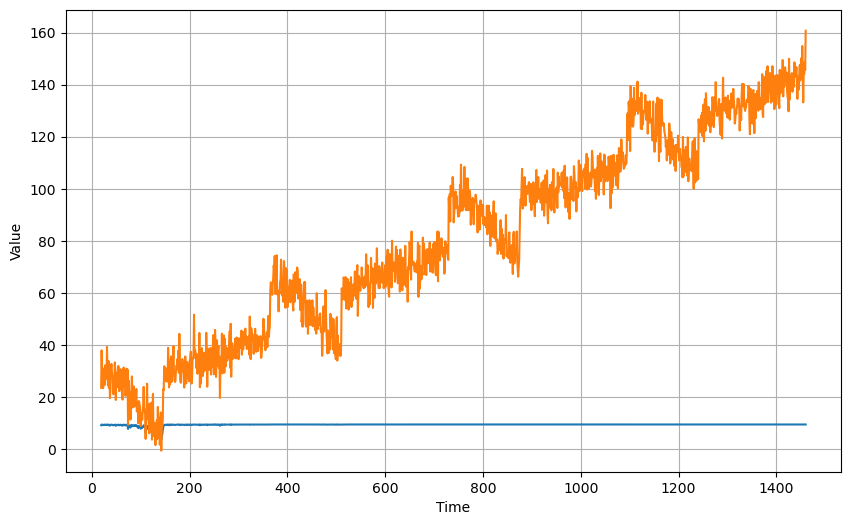

In [ ]:
# Plot of results and calculate MAE score

results = forecast * std + mean
mae = tf.keras.metrics.MeanAbsoluteError()
MAE = mae(series[window_size -1:], results).numpy()
print(MAE)

plt.figure(figsize=(10, 6))
plot_series(time[split_time+ window_size -1:], results[split_time:])
plot_series(time[split_time+ window_size -1::], series[split_time+ window_size -1::])


In [ ]:
# Using Bidirectional GRUs (Gated Recurrent Unit) RNN with Dropout

model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(100, input_shape=[None, 1],return_sequences=True, 
    dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Dense(1),
    ])

optimizer = tf.keras.optimizers.SGD(learning_rate=1.5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), 
    optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100,  verbose=1, steps_per_epoch=split_time // batch_size)

In [ ]:
# Plot of results and calculate MAE score

results = forecast * std + mean
mae = tf.keras.metrics.MeanAbsoluteError()
MAE = mae(series[window_size -1:], results).numpy()
print(MAE)

plt.figure(figsize=(10, 6))
plot_series(time[split_time+ window_size -1:], results[split_time:])
plot_series(time[split_time+ window_size -1::], series[split_time+ window_size -1::])
